In [1]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.stats import norm
from scipy.optimize import minimize
import sys
import pandas as pd

import sys
sys.path.append('../pyJive/')
from utils import proputils as pu
import main
from names import GlobNames as gn
%matplotlib widget

def costly_function(x):
    total = np.array([])
    for x_i in x:
        total = np.append(total, np.sum(np.exp(-(x_i - 5) ** 2)))
    
    return total + np.random.randn()

In [2]:
class BayesianOptimizer():
      
    def __init__(self, target_func, x_init, y_init, n_iter, scale, batch_size):
        self.x_init = x_init
        self.y_init = y_init
        self.target_func = target_func
        self.n_iter = n_iter
        self.scale = scale
        self.batch_size = batch_size
        self.gauss_pr = GaussianProcessRegressor()
        self.best_samples_ = pd.DataFrame(columns = ['x', 'y', 'ei'])
        self.distances_ = []

    def _get_expected_improvement(self, x_new):

        # Using estimate from Gaussian surrogate instead of actual function for 
        # a new trial data point to avoid cost 
 
        mean_y_new, sigma_y_new = self.gauss_pr.predict(np.array([x_new]), return_std=True)
        sigma_y_new = sigma_y_new.reshape(-1,1)
        if sigma_y_new == 0.0:
            return 0.0
        
        # Using estimates from Gaussian surrogate instead of actual function for 
        # entire prior distribution to avoid cost
        
        mean_y = self.gauss_pr.predict(self.x_init)
        max_mean_y = np.max(mean_y)
        z = (mean_y_new - max_mean_y) / sigma_y_new
        exp_imp = (mean_y_new - max_mean_y) * norm.cdf(z) + sigma_y_new * norm.pdf(z)
        
        return exp_imp
    
    def _acquisition_function(self, x):
        return -self._get_expected_improvement(x)
        
    def _get_next_probable_point(self):
            min_ei = float(sys.maxsize)
            x_optimal = None 
                
            # Trial with an array of random data points
                
            for x_start in (np.random.random((self.batch_size,self.x_init.shape[1])) * self.scale):
                response = minimize(fun=self._acquisition_function, x0=x_start, method='L-BFGS-B')
                # print(response.fun)
                # if response.fun[0] < min_ei:
                if response.fun < min_ei:
                    # min_ei = response.fun[0]
                    min_ei = response.fun
                    x_optimal = response.x
                
                return x_optimal, min_ei
    def _extend_prior_with_posterior_data(self, x,y):
        self.x_init = np.append(self.x_init, np.array([x]), axis = 0)
        self.y_init = np.append(self.y_init, np.array(y), axis = 0)
  
    def optimize(self):
        y_max_ind = np.argmax(self.y_init)
        y_max = self.y_init[y_max_ind]
        optimal_x = self.x_init[y_max_ind]
        optimal_ei = None
        for i in range(self.n_iter):
            self.gauss_pr.fit(self.x_init, self.y_init)
            x_next, ei = self._get_next_probable_point()
            y_next = self.target_func(np.array([x_next]))
            self._extend_prior_with_posterior_data(x_next,y_next)
                
            if y_next[0] > y_max:
                y_max = y_next[0]
                optimal_x = x_next
                # optimal_ei = ei[0]
                optimal_ei = ei

            if i == 0:
                prev_x = x_next
            else:
                self.distances_.append(np.linalg.norm(prev_x - x_next))
                prev_x = x_next
                
            self.best_samples_ = pd.concat((self.best_samples_, pd.DataFrame({"y": [y_max], "ei": [optimal_ei]})), ignore_index=True)
            
        return optimal_x, y_max
            

Getting initial guesses

Initializing module chain...
InitModule: Creating DofSpace...
InitModule: Reading geo mesh file bridge.geom ...
InitModule: Creating node groups...
InitModule: Created group bl with nodes [0]
InitModule: Created group br with nodes [19]
InitModule: Created group bm with nodes [9]
InitModule: Created group bottom with nodes [ 0  1  3  5  7  9 11 13 15 17 19]
InitModule: Creating model...
Creating Line2Shape...
mass  using all doftypes by default:  dict_keys(['dx', 'dy'])
Running chain...
ModeShapeModule: running eigenvalue problem...
ModeShapeModule: smallest natural frequency  9.2716e+01 rad / s


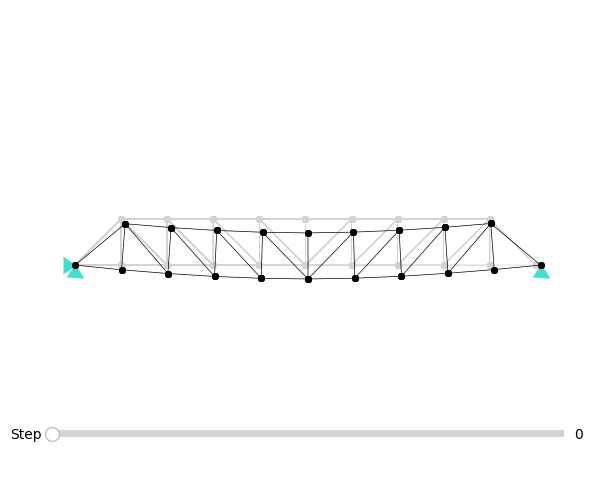

End of execution
Initializing module chain...
InitModule: Creating DofSpace...
InitModule: Reading geo mesh file bridge.geom ...
InitModule: Creating node groups...
InitModule: Created group bl with nodes [0]
InitModule: Created group br with nodes [19]
InitModule: Created group bm with nodes [9]
InitModule: Created group bottom with nodes [ 0  1  3  5  7  9 11 13 15 17 19]
InitModule: Creating model...
Creating Line2Shape...
mass  using all doftypes by default:  dict_keys(['dx', 'dy'])
Running chain...
ModeShapeModule: running eigenvalue problem...
ModeShapeModule: smallest natural frequency  9.2716e+01 rad / s


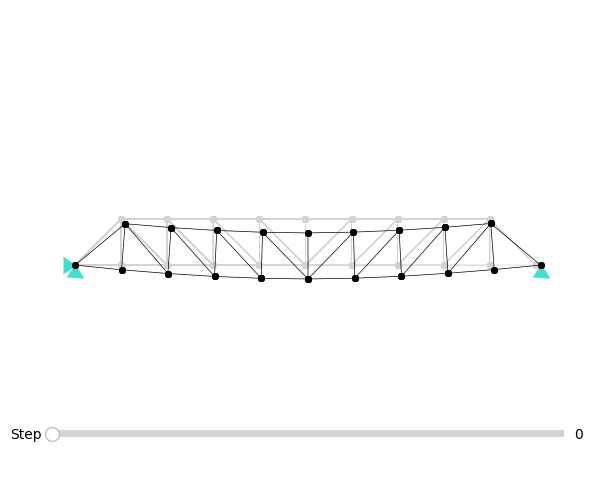

End of execution
Initializing module chain...
InitModule: Creating DofSpace...
InitModule: Reading geo mesh file bridge.geom ...
InitModule: Creating node groups...
InitModule: Created group bl with nodes [0]
InitModule: Created group br with nodes [19]
InitModule: Created group bm with nodes [9]
InitModule: Created group bottom with nodes [ 0  1  3  5  7  9 11 13 15 17 19]
InitModule: Creating model...
Creating Line2Shape...
mass  using all doftypes by default:  dict_keys(['dx', 'dy'])
Running chain...
ModeShapeModule: running eigenvalue problem...
ModeShapeModule: smallest natural frequency  9.2716e+01 rad / s


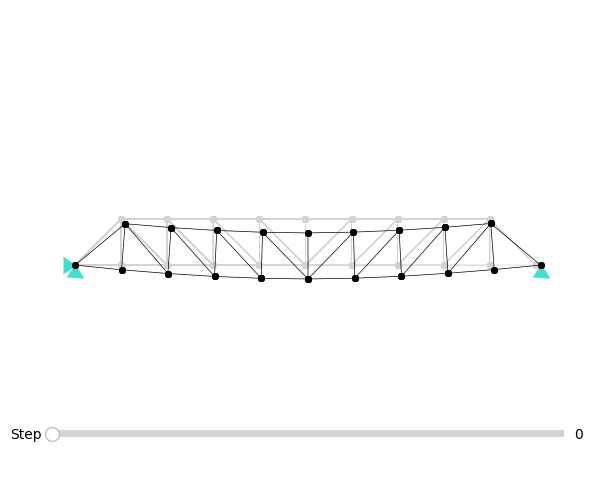

End of execution
Initializing module chain...
InitModule: Creating DofSpace...
InitModule: Reading geo mesh file bridge.geom ...
InitModule: Creating node groups...
InitModule: Created group bl with nodes [0]
InitModule: Created group br with nodes [19]
InitModule: Created group bm with nodes [9]
InitModule: Created group bottom with nodes [ 0  1  3  5  7  9 11 13 15 17 19]
InitModule: Creating model...
Creating Line2Shape...
mass  using all doftypes by default:  dict_keys(['dx', 'dy'])
Running chain...
ModeShapeModule: running eigenvalue problem...
ModeShapeModule: smallest natural frequency  9.2716e+01 rad / s


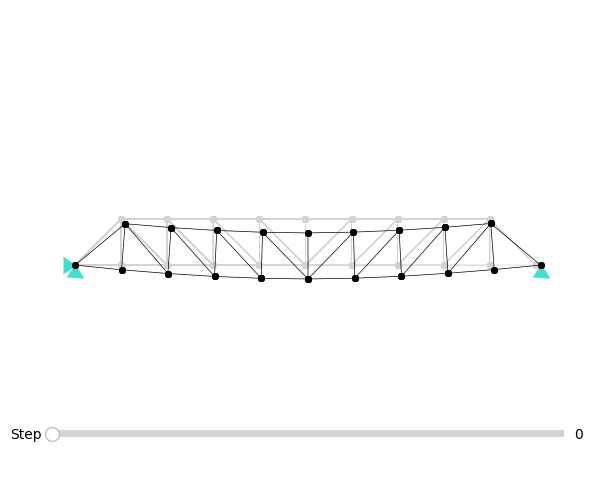

End of execution
Initializing module chain...
InitModule: Creating DofSpace...
InitModule: Reading geo mesh file bridge.geom ...
InitModule: Creating node groups...
InitModule: Created group bl with nodes [0]
InitModule: Created group br with nodes [19]
InitModule: Created group bm with nodes [9]
InitModule: Created group bottom with nodes [ 0  1  3  5  7  9 11 13 15 17 19]
InitModule: Creating model...
Creating Line2Shape...
mass  using all doftypes by default:  dict_keys(['dx', 'dy'])
Running chain...
ModeShapeModule: running eigenvalue problem...
ModeShapeModule: smallest natural frequency  9.2716e+01 rad / s


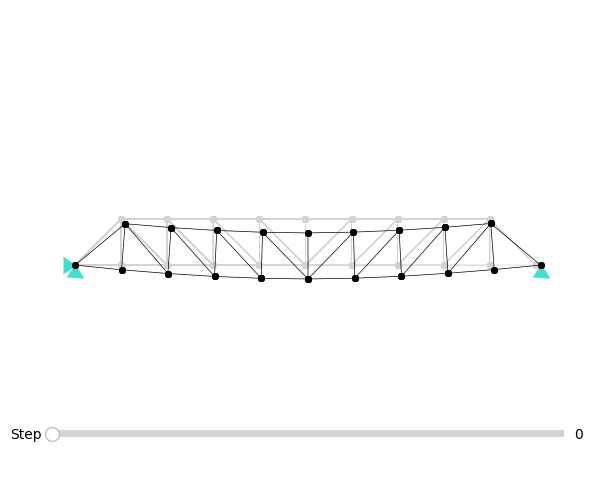

End of execution
Initializing module chain...
InitModule: Creating DofSpace...
InitModule: Reading geo mesh file bridge.geom ...
InitModule: Creating node groups...
InitModule: Created group bl with nodes [0]
InitModule: Created group br with nodes [19]
InitModule: Created group bm with nodes [9]
InitModule: Created group bottom with nodes [ 0  1  3  5  7  9 11 13 15 17 19]
InitModule: Creating model...
Creating Line2Shape...
mass  using all doftypes by default:  dict_keys(['dx', 'dy'])
Running chain...
ModeShapeModule: running eigenvalue problem...
ModeShapeModule: smallest natural frequency  9.2716e+01 rad / s


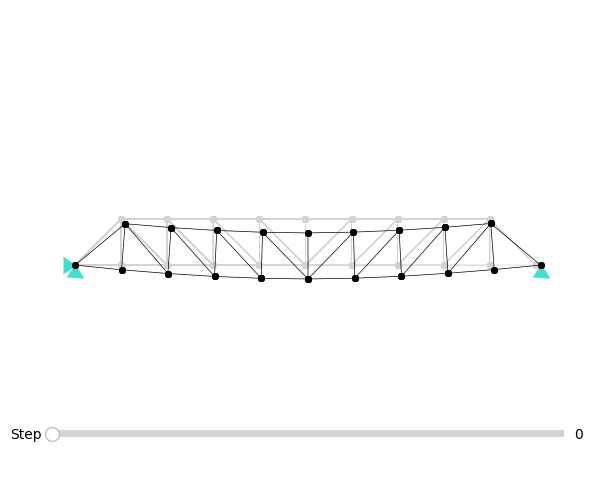

End of execution
Initializing module chain...
InitModule: Creating DofSpace...
InitModule: Reading geo mesh file bridge.geom ...
InitModule: Creating node groups...
InitModule: Created group bl with nodes [0]
InitModule: Created group br with nodes [19]
InitModule: Created group bm with nodes [9]
InitModule: Created group bottom with nodes [ 0  1  3  5  7  9 11 13 15 17 19]
InitModule: Creating model...
Creating Line2Shape...
mass  using all doftypes by default:  dict_keys(['dx', 'dy'])
Running chain...
ModeShapeModule: running eigenvalue problem...
ModeShapeModule: smallest natural frequency  9.2716e+01 rad / s


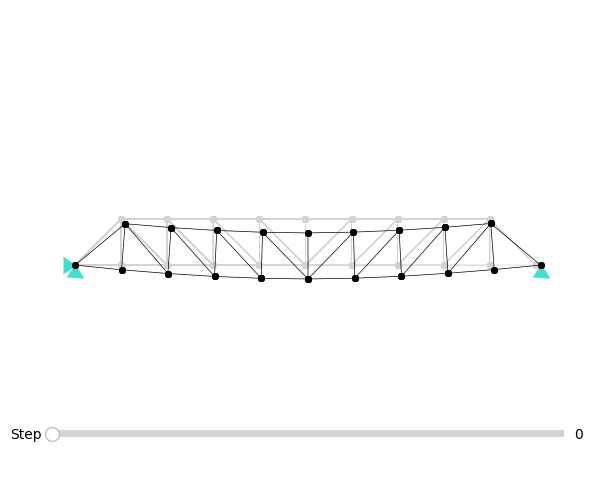

End of execution
Initializing module chain...
InitModule: Creating DofSpace...
InitModule: Reading geo mesh file bridge.geom ...
InitModule: Creating node groups...
InitModule: Created group bl with nodes [0]
InitModule: Created group br with nodes [19]
InitModule: Created group bm with nodes [9]
InitModule: Created group bottom with nodes [ 0  1  3  5  7  9 11 13 15 17 19]
InitModule: Creating model...
Creating Line2Shape...
mass  using all doftypes by default:  dict_keys(['dx', 'dy'])
Running chain...
ModeShapeModule: running eigenvalue problem...
ModeShapeModule: smallest natural frequency  9.2716e+01 rad / s


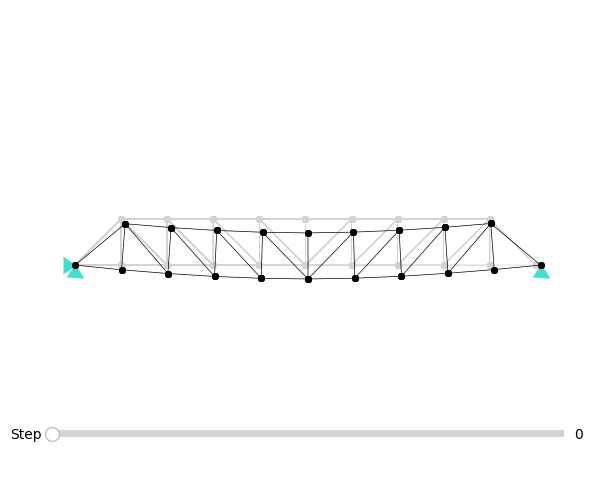

End of execution
Initializing module chain...
InitModule: Creating DofSpace...
InitModule: Reading geo mesh file bridge.geom ...
InitModule: Creating node groups...
InitModule: Created group bl with nodes [0]
InitModule: Created group br with nodes [19]
InitModule: Created group bm with nodes [9]
InitModule: Created group bottom with nodes [ 0  1  3  5  7  9 11 13 15 17 19]
InitModule: Creating model...
Creating Line2Shape...
mass  using all doftypes by default:  dict_keys(['dx', 'dy'])
Running chain...
ModeShapeModule: running eigenvalue problem...
ModeShapeModule: smallest natural frequency  9.2716e+01 rad / s


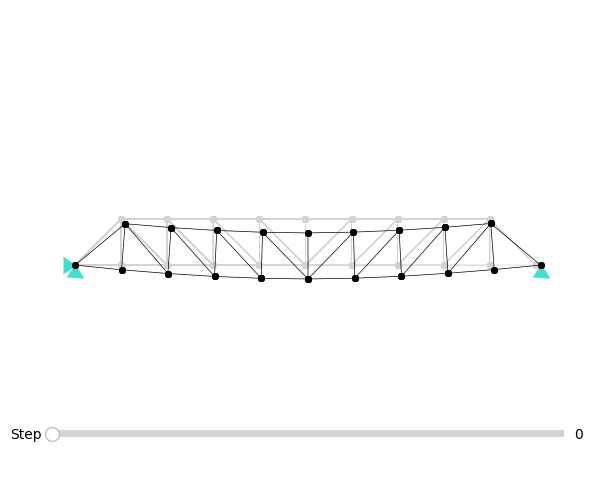

End of execution
Initializing module chain...
InitModule: Creating DofSpace...
InitModule: Reading geo mesh file bridge.geom ...
InitModule: Creating node groups...
InitModule: Created group bl with nodes [0]
InitModule: Created group br with nodes [19]
InitModule: Created group bm with nodes [9]
InitModule: Created group bottom with nodes [ 0  1  3  5  7  9 11 13 15 17 19]
InitModule: Creating model...
Creating Line2Shape...
mass  using all doftypes by default:  dict_keys(['dx', 'dy'])
Running chain...
ModeShapeModule: running eigenvalue problem...
ModeShapeModule: smallest natural frequency  9.2716e+01 rad / s


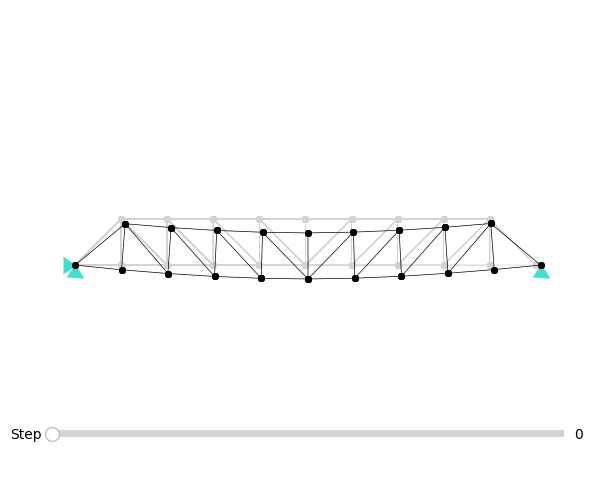

End of execution
Initializing module chain...
InitModule: Creating DofSpace...
InitModule: Reading geo mesh file bridge.geom ...
InitModule: Creating node groups...
InitModule: Created group bl with nodes [0]
InitModule: Created group br with nodes [19]
InitModule: Created group bm with nodes [9]
InitModule: Created group bottom with nodes [ 0  1  3  5  7  9 11 13 15 17 19]
InitModule: Creating model...
Creating Line2Shape...
mass  using all doftypes by default:  dict_keys(['dx', 'dy'])
Running chain...
ModeShapeModule: running eigenvalue problem...
ModeShapeModule: smallest natural frequency  9.2716e+01 rad / s


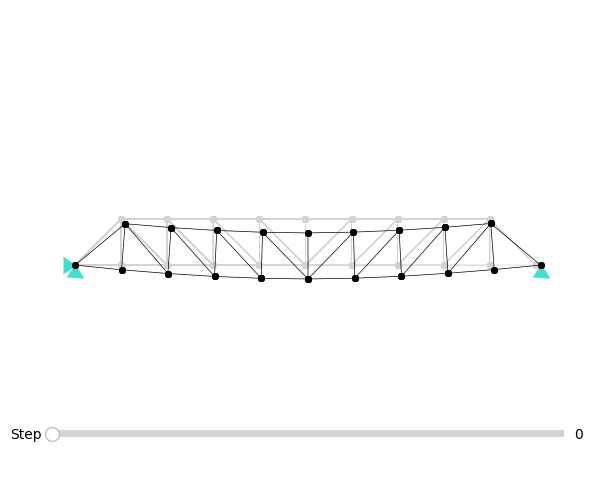

End of execution
Initializing module chain...
InitModule: Creating DofSpace...
InitModule: Reading geo mesh file bridge.geom ...
InitModule: Creating node groups...
InitModule: Created group bl with nodes [0]
InitModule: Created group br with nodes [19]
InitModule: Created group bm with nodes [9]
InitModule: Created group bottom with nodes [ 0  1  3  5  7  9 11 13 15 17 19]
InitModule: Creating model...
Creating Line2Shape...
mass  using all doftypes by default:  dict_keys(['dx', 'dy'])
Running chain...
ModeShapeModule: running eigenvalue problem...
ModeShapeModule: smallest natural frequency  9.2716e+01 rad / s


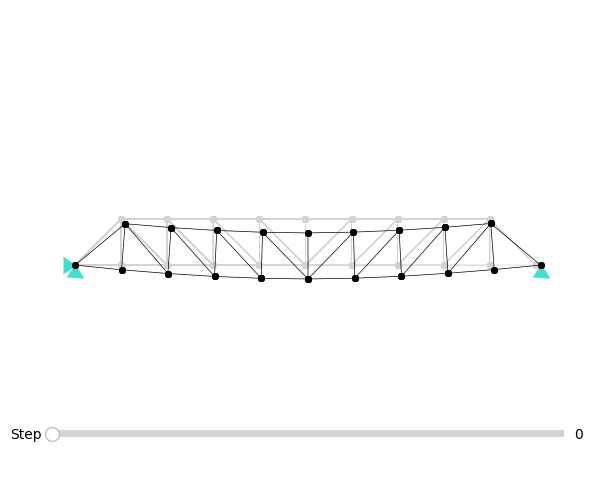

End of execution
Initializing module chain...
InitModule: Creating DofSpace...
InitModule: Reading geo mesh file bridge.geom ...
InitModule: Creating node groups...
InitModule: Created group bl with nodes [0]
InitModule: Created group br with nodes [19]
InitModule: Created group bm with nodes [9]
InitModule: Created group bottom with nodes [ 0  1  3  5  7  9 11 13 15 17 19]
InitModule: Creating model...
Creating Line2Shape...
mass  using all doftypes by default:  dict_keys(['dx', 'dy'])
Running chain...
ModeShapeModule: running eigenvalue problem...
ModeShapeModule: smallest natural frequency  9.2716e+01 rad / s


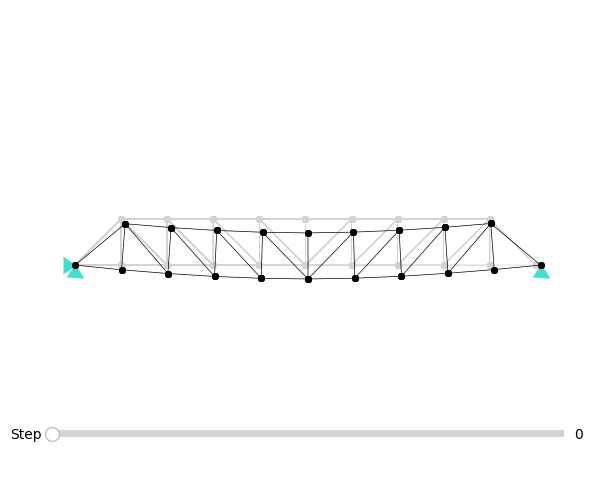

End of execution
Initializing module chain...
InitModule: Creating DofSpace...
InitModule: Reading geo mesh file bridge.geom ...
InitModule: Creating node groups...
InitModule: Created group bl with nodes [0]
InitModule: Created group br with nodes [19]
InitModule: Created group bm with nodes [9]
InitModule: Created group bottom with nodes [ 0  1  3  5  7  9 11 13 15 17 19]
InitModule: Creating model...
Creating Line2Shape...
mass  using all doftypes by default:  dict_keys(['dx', 'dy'])
Running chain...
ModeShapeModule: running eigenvalue problem...
ModeShapeModule: smallest natural frequency  9.2716e+01 rad / s


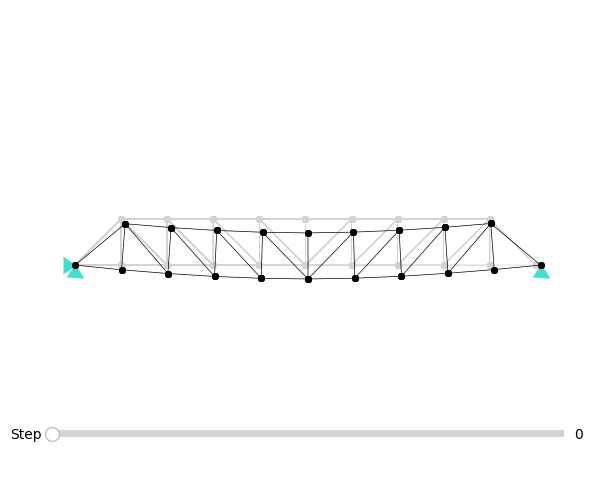

End of execution
Initializing module chain...
InitModule: Creating DofSpace...
InitModule: Reading geo mesh file bridge.geom ...
InitModule: Creating node groups...
InitModule: Created group bl with nodes [0]
InitModule: Created group br with nodes [19]
InitModule: Created group bm with nodes [9]
InitModule: Created group bottom with nodes [ 0  1  3  5  7  9 11 13 15 17 19]
InitModule: Creating model...
Creating Line2Shape...
mass  using all doftypes by default:  dict_keys(['dx', 'dy'])
Running chain...
ModeShapeModule: running eigenvalue problem...
ModeShapeModule: smallest natural frequency  9.2716e+01 rad / s


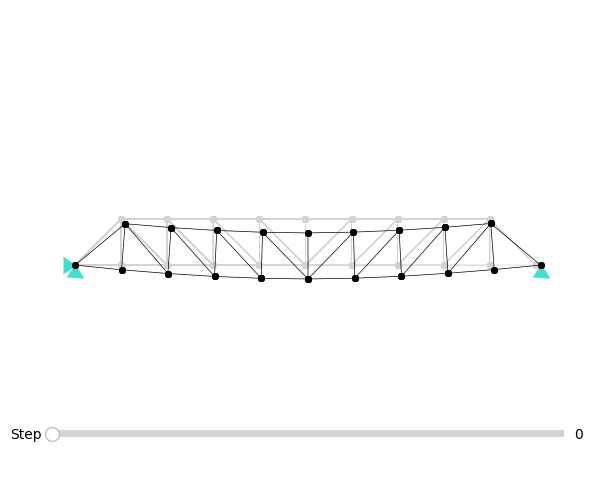

End of execution
Initializing module chain...
InitModule: Creating DofSpace...
InitModule: Reading geo mesh file bridge.geom ...
InitModule: Creating node groups...
InitModule: Created group bl with nodes [0]
InitModule: Created group br with nodes [19]
InitModule: Created group bm with nodes [9]
InitModule: Created group bottom with nodes [ 0  1  3  5  7  9 11 13 15 17 19]
InitModule: Creating model...
Creating Line2Shape...
mass  using all doftypes by default:  dict_keys(['dx', 'dy'])
Running chain...
ModeShapeModule: running eigenvalue problem...
ModeShapeModule: smallest natural frequency  9.2716e+01 rad / s


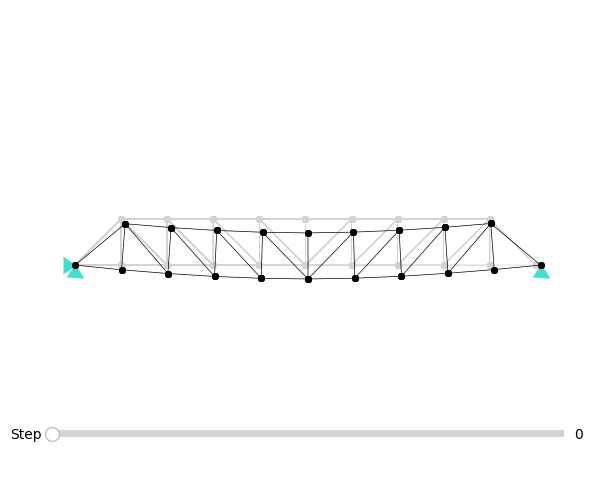

End of execution
Initializing module chain...
InitModule: Creating DofSpace...
InitModule: Reading geo mesh file bridge.geom ...
InitModule: Creating node groups...
InitModule: Created group bl with nodes [0]
InitModule: Created group br with nodes [19]
InitModule: Created group bm with nodes [9]
InitModule: Created group bottom with nodes [ 0  1  3  5  7  9 11 13 15 17 19]
InitModule: Creating model...
Creating Line2Shape...
mass  using all doftypes by default:  dict_keys(['dx', 'dy'])
Running chain...
ModeShapeModule: running eigenvalue problem...
ModeShapeModule: smallest natural frequency  9.2716e+01 rad / s


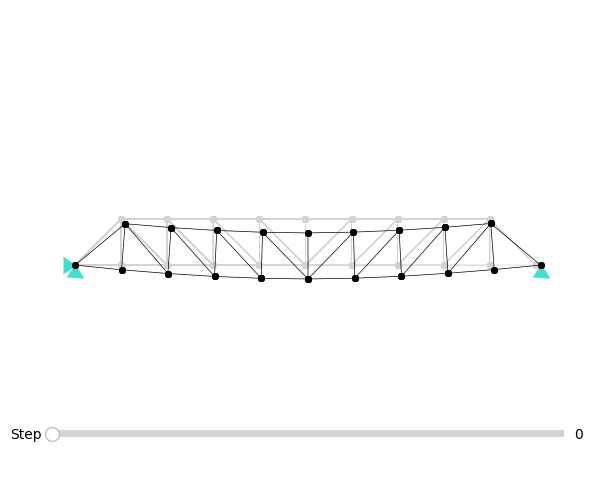

End of execution
Initializing module chain...
InitModule: Creating DofSpace...
InitModule: Reading geo mesh file bridge.geom ...
InitModule: Creating node groups...
InitModule: Created group bl with nodes [0]
InitModule: Created group br with nodes [19]
InitModule: Created group bm with nodes [9]
InitModule: Created group bottom with nodes [ 0  1  3  5  7  9 11 13 15 17 19]
InitModule: Creating model...
Creating Line2Shape...
mass  using all doftypes by default:  dict_keys(['dx', 'dy'])
Running chain...
ModeShapeModule: running eigenvalue problem...
ModeShapeModule: smallest natural frequency  9.2716e+01 rad / s


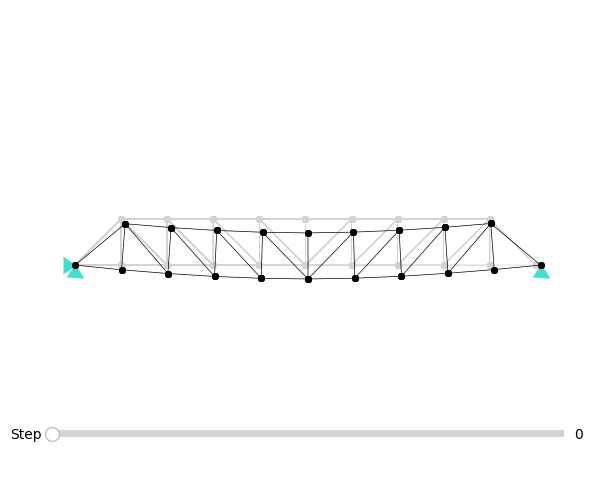

End of execution
Initializing module chain...
InitModule: Creating DofSpace...
InitModule: Reading geo mesh file bridge.geom ...
InitModule: Creating node groups...
InitModule: Created group bl with nodes [0]
InitModule: Created group br with nodes [19]
InitModule: Created group bm with nodes [9]
InitModule: Created group bottom with nodes [ 0  1  3  5  7  9 11 13 15 17 19]
InitModule: Creating model...
Creating Line2Shape...
mass  using all doftypes by default:  dict_keys(['dx', 'dy'])
Running chain...
ModeShapeModule: running eigenvalue problem...
ModeShapeModule: smallest natural frequency  9.2716e+01 rad / s


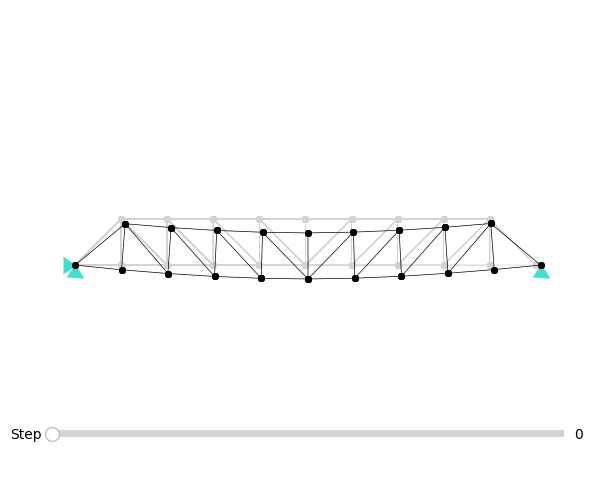

End of execution
Initializing module chain...
InitModule: Creating DofSpace...
InitModule: Reading geo mesh file bridge.geom ...
InitModule: Creating node groups...
InitModule: Created group bl with nodes [0]
InitModule: Created group br with nodes [19]
InitModule: Created group bm with nodes [9]
InitModule: Created group bottom with nodes [ 0  1  3  5  7  9 11 13 15 17 19]
InitModule: Creating model...
Creating Line2Shape...
mass  using all doftypes by default:  dict_keys(['dx', 'dy'])
Running chain...
ModeShapeModule: running eigenvalue problem...
ModeShapeModule: smallest natural frequency  9.2716e+01 rad / s


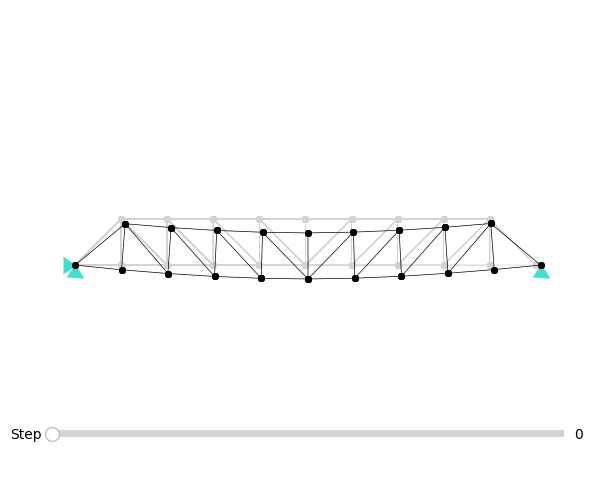

End of execution


In [3]:
props = pu.parse_file('bridge_frequency.pro')
#props['model']['truss']['area'] = [ 40e-4, 3.1997e-4, 1.0025e-4, 1.0000e-4, 2.5875e-4, 1.0895e-4, 1.1261e-4, 2.5624e-4, 1.4121e-4, 1.5758e-4, 2.2461e-4, 1.0694e-4, 1.3193e-4, 2.3846e-4, 1.0001e-4 ]
def x_init_rand(props, length):
    x = []
    for i in range(length):
        x_i = props
        x_i['model']['truss']['area'] = np.random.uniform(1.0e-4, 3.0e-4, 15)
        x.append(x_i)
    
    return x

def y_init(x):
    y = []
    for d in x:
        y.append(main.jive(d))
    return y

x = x_init_rand(props, 20)
y = y_init(x)

Initializing module chain...
InitModule: Creating DofSpace...
InitModule: Reading geo mesh file bridge.geom ...
InitModule: Creating node groups...
InitModule: Created group bl with nodes [0]
InitModule: Created group br with nodes [19]
InitModule: Created group bm with nodes [9]
InitModule: Created group bottom with nodes [ 0  1  3  5  7  9 11 13 15 17 19]
InitModule: Creating model...
Creating Line2Shape...
mass  using all doftypes by default:  dict_keys(['dx', 'dy'])
Running chain...
ModeShapeModule: running eigenvalue problem...
ModeShapeModule: smallest natural frequency  8.7640e+01 rad / s


c:\Users\31636\DSAIE\Truss git\TRUSS1\truss_bridge\../pyJive\modules\frameviewmodule.py:191: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


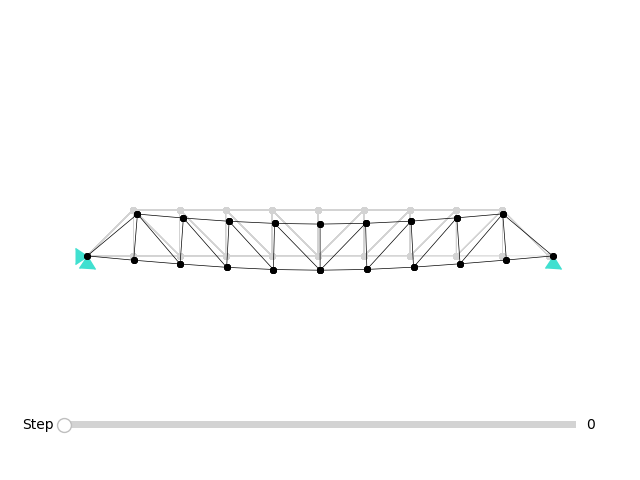

End of execution


KeyError: 0

In [5]:
bopt = BayesianOptimizer(target_func=main.jive, x_init=props, y_init=main.jive(props), n_iter=200, scale=10, batch_size=30)
bopt.optimize()

<Axes: >

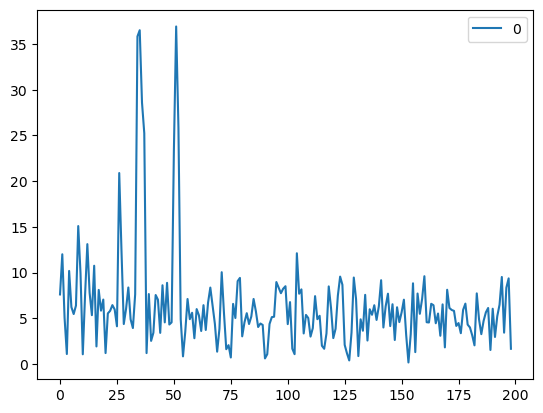

In [32]:
pd.DataFrame(bopt.distances_).plot()

<Axes: >

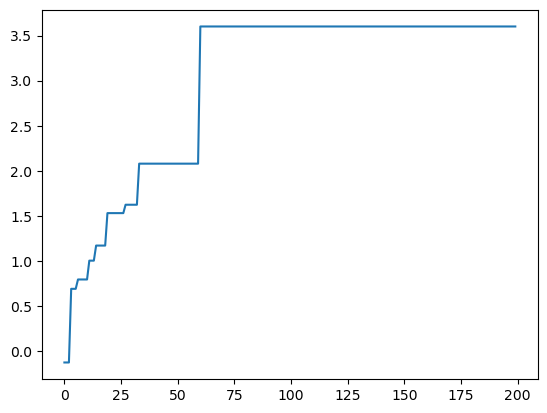

In [33]:
bopt.best_samples_['y'].plot()

<Axes: >

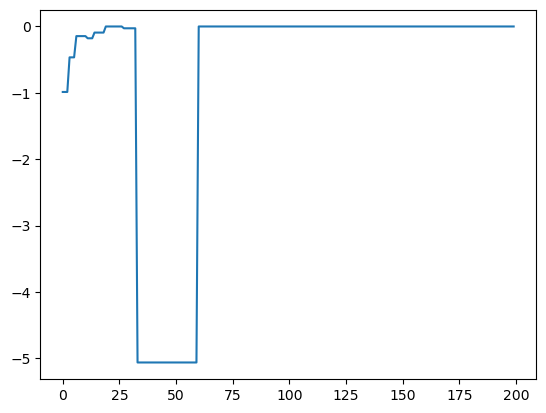

In [34]:
bopt.best_samples_['ei'].plot()